Loan Approval Prediction
- 贷款审批是否通过（二分类问题）
- 关键特征：收入、信用评分、贷款金额、就业状态、负债比

# Import Libraries

In [78]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import math
from sklearn.preprocessing import OrdinalEncoder

from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from matplotlib.patches import ConnectionPatch

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Load Dataset

In [79]:
train_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")

In [80]:
print("train_df shape={}".format(train_df.shape))
print("test_df shape={}".format(test_df.shape))

train_df shape=(58645, 13)
test_df shape=(39098, 12)


In [81]:
sub_df = pd.DataFrame()
sub_df['id']=test_df['id']

# Explore the Data

In [82]:
train_df.drop('id',axis=1,inplace=True)
test_df.drop('id',axis=1,inplace=True)

In [83]:
#features names
print(train_df.columns.values)

['person_age' 'person_income' 'person_home_ownership' 'person_emp_length'
 'loan_intent' 'loan_grade' 'loan_amnt' 'loan_int_rate'
 'loan_percent_income' 'cb_person_default_on_file'
 'cb_person_cred_hist_length' 'loan_status']


In [84]:
train_df.info()
train_df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.4+ MB


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
27357,23,45000,RENT,0.0,DEBTCONSOLIDATION,C,1200,13.80,0.03,N,2,0
31968,25,80000,RENT,1.0,EDUCATION,B,20000,10.25,0.25,N,4,1
26334,30,30000,RENT,3.0,MEDICAL,C,6000,14.22,0.20,N,8,1
12933,25,92000,MORTGAGE,9.0,VENTURE,B,20000,12.42,0.22,N,3,0
15358,23,54000,RENT,7.0,PERSONAL,B,4000,11.71,0.07,N,4,0
14954,24,30000,RENT,2.0,DEBTCONSOLIDATION,B,6000,10.38,0.20,N,2,0
13306,22,60000,MORTGAGE,0.0,EDUCATION,A,8000,7.29,0.13,N,3,0
39918,25,58000,RENT,9.0,EDUCATION,C,15900,13.04,0.27,N,2,0
11447,22,48000,RENT,6.0,MEDICAL,B,6000,9.99,0.13,N,4,0
56927,21,30000,RENT,3.0,PERSONAL,C,7000,15.27,0.22,N,4,0


In [85]:
test_df.info()
test_df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.3+ MB


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
21485,32,70000,MORTGAGE,5.0,PERSONAL,B,8400,12.69,0.12,N,6
23683,24,48000,RENT,0.0,MEDICAL,B,12000,10.37,0.25,N,2
37581,24,31200,RENT,1.0,MEDICAL,D,10000,15.33,0.32,N,2
20379,24,100000,MORTGAGE,6.0,DEBTCONSOLIDATION,A,15000,6.54,0.15,N,4
16017,32,45996,RENT,12.0,EDUCATION,D,1800,14.96,0.04,Y,6
10262,26,90000,MORTGAGE,10.0,HOMEIMPROVEMENT,B,2500,9.91,0.03,N,3
8685,25,60000,MORTGAGE,1.0,MEDICAL,B,15000,10.37,0.25,N,3
30521,25,106000,MORTGAGE,2.0,HOMEIMPROVEMENT,B,12000,11.71,0.11,N,4
37682,36,40000,RENT,0.0,VENTURE,B,2800,10.00,0.07,N,13
17579,24,30000,RENT,4.0,MEDICAL,D,7000,15.65,0.23,N,2


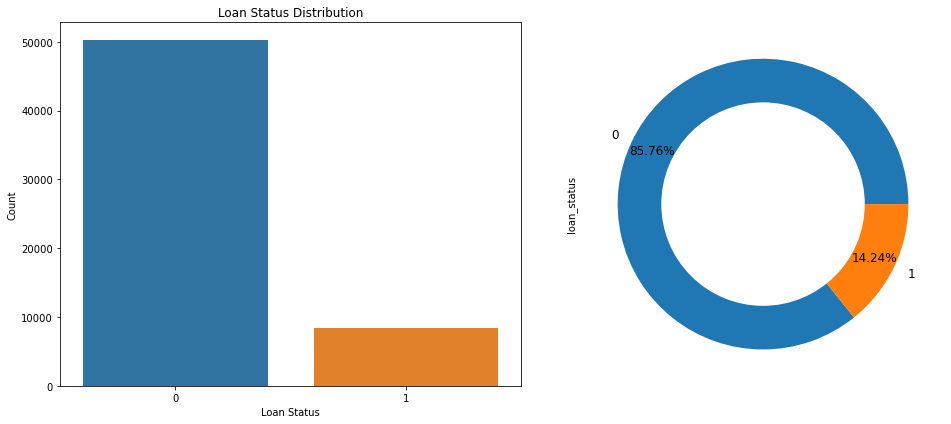

In [86]:
# Target : loan_status 看是否平衡？
plt.figure(figsize=(14,6))
#将画布分成 1 行 2 列，这里绘制第 1 个子图。
plt.subplot(1, 2, 1)
sns.countplot(x='loan_status', data=train_df)
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')
#第2个子图
plt.subplot(1, 2, 2)
train_df['loan_status'].value_counts().plot.pie(autopct='%.2f%%', pctdistance=0.85, fontsize=12) #autopct='%.2f%%'：显示百分比，保留 2 位小数。
plt.gca().add_artist(plt.Circle((0,0),radius=0.7,fc='white'))
plt.tight_layout()
plt.show()


- 不平衡数据的影响
1. 模型偏向多数类：大部分机器学习模型假设类别分布是平衡的，因此可能倾向于预测多数类别，导致少数类别被忽略。(样本中90%是“批准”，10%是“拒绝”，模型如果都预测为“批准”，那准确率仍然会很高，但没用。)
2. 评价指标失真 ：更适合用 F1-score（平衡精确率和召回率） AUC-ROC（衡量模型区分正负样本的能力）Recall（对少数类更敏感，避免漏掉重要样本）
- 如何处理类别不平衡？
1. 重采样策略：
   - 欠采样（Undersampling）：随机减少多数类样本，使类别分布更平衡，但可能丢失有价值的信息。
   - 过采样（Oversampling）：增加少数类样本，比如用 SMOTE（合成少数类过采样技术）生成新的少数类样本，防止过拟合。
2. 加权模型：一些模型支持对类别设置权重，比如 逻辑回归、随机森林 和 XGBoost。

In [87]:
#the distribution of numerical feature values
train_df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [88]:
#  the distribution of categorical features
train_df.describe(exclude=[np.number])

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,58645,58645,58645,58645
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,30594,12271,20984,49943


Feature Description
1. person_age：贷款申请人的年龄。年龄可能是财务稳定性、经验和还款行为的指标。
2. person_income：贷款申请人的年收入。较高的收入通常与更强的还款能力相关。
3. person_home_ownership：表示申请人是自有住房、租房还是按揭贷款。拥有房产通常是财务稳定的标志，拥有资产可能降低违约风险。
4. person_emp_length：申请人的工作年限。更长的工作历史通常表明工作稳定性，这对贷款审批有积极影响。
5. loan_intent：贷款的用途（如教育、医疗、个人消费等）。不同的贷款用途可能具有不同的风险水平。
6. loan_grade：申请人的信用等级或评分分类。这通常是预测借款人信用worthiness（信用可靠性）的关键指标。
7. loan_amnt：申请人申请的贷款金额。较高的贷款金额可能对贷方构成更高风险，尤其是当借款人的财务能力有限时。
8. loan_int_rate：贷款利率。这可能反映申请人的信用状况和贷款的感知风险。较高的利率通常伴随着较高的借款人风险。
9. loan_percent_income：贷款金额与申请人收入的比例。这个比例衡量贷款相对于申请人收入的负担，较高的比例可能意味着更高的违约风险。
10. cb_person_default_on_file：指示申请人是否有过贷款违约记录（是/否）。违约历史是未来违约风险的重要预测指标。
11. cb_person_cred_hist_length：申请人的信用历史长度（年）。更长的信用历史提供了更多评估申请人财务行为的数据，通常有助于更准确的风险评估。

d:\Python\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
d:\Python\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


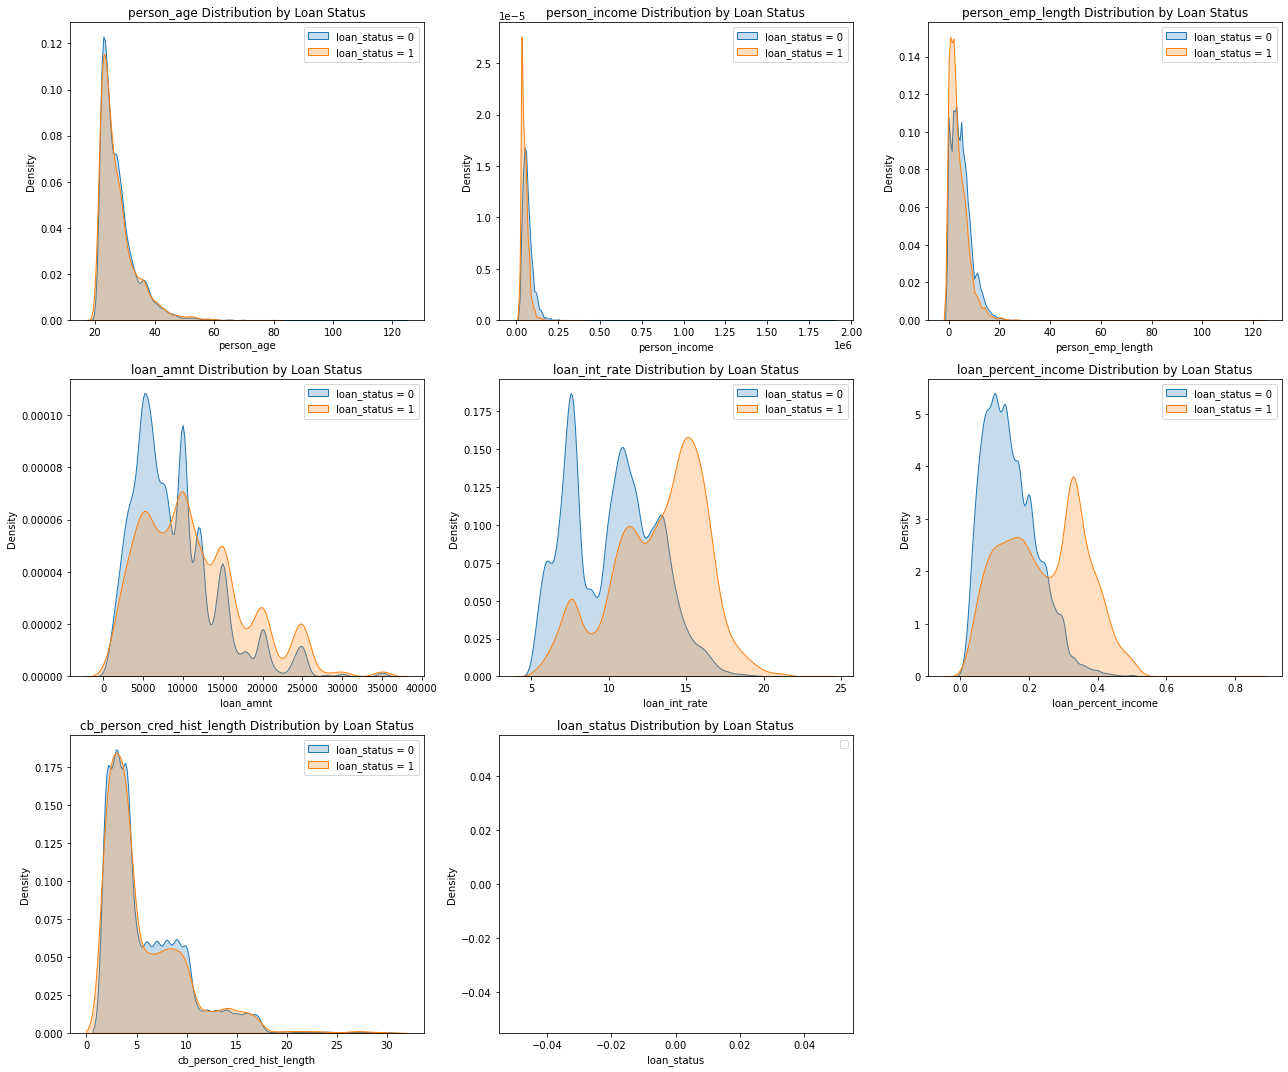

In [89]:
#numerical features 在loan_status为0和1时的概率密度函数分布
numeric_columns = train_df.select_dtypes(include=['int','float']).columns
#每行放 3 个子图，计算需要多少行才能展示所有特征的分布。
num_cols = len(numeric_columns)
cols = 3 
rows = math.ceil(num_cols / cols)
#创建子图网格
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 5))
axes = axes.reshape(-1)
#绘制 KDE 图（核密度估计图）
for i, column in enumerate(numeric_columns):
    sns.kdeplot(train_df[train_df['loan_status'] == 0][column], label='loan_status = 0', shade=True, ax=axes[i])
    sns.kdeplot(train_df[train_df['loan_status'] == 1][column], label='loan_status = 1', shade=True, ax=axes[i])
    #添加标题和标签
    axes[i].set_title(f'{column} Distribution by Loan Status')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Density')
    axes[i].legend()
#清理多余子图：如果子图格子多于实际列数，删除多余的空白子图。
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

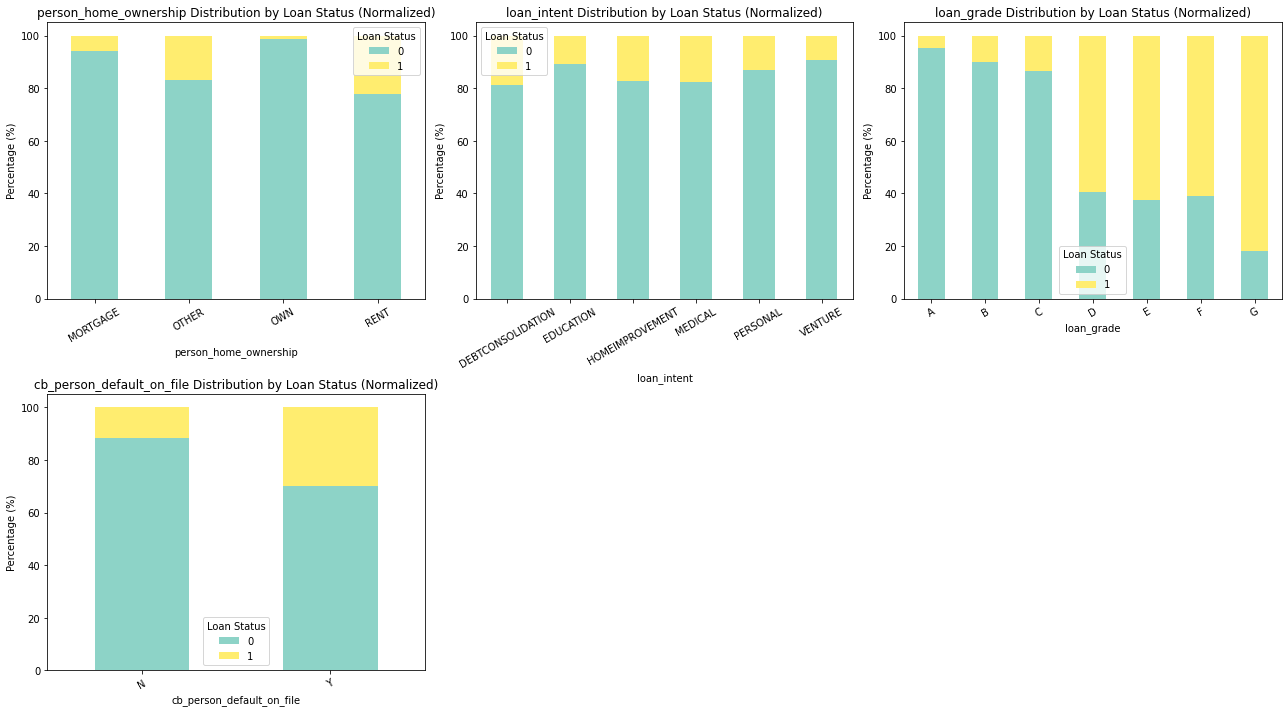

In [90]:
#categorical features
categorical_columns = train_df.select_dtypes(include=['object']).columns

num_cols = 3
rows = math.ceil(len(categorical_columns) / num_cols)

fig, axes = plt.subplots(rows, num_cols, figsize=(18, rows * 5))
axes = axes.reshape(-1)

for i, column in enumerate(categorical_columns):
    # 交叉表计算每个类别在 loan_status 下的分布，并标准化为百分比
    cross_tab = pd.crosstab(train_df[column], train_df['loan_status'], normalize='index') * 100
    
    # 绘制堆叠条形图
    cross_tab.plot(kind='bar', stacked=True, ax=axes[i], colormap='Set3')
    
    axes[i].set_title(f'{column} Distribution by Loan Status (Normalized)')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Percentage (%)')
    axes[i].legend(title='Loan Status')
    axes[i].tick_params(axis='x', rotation=30)

# 删除多余的空白子图
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


<ipython-input-91-01e5cd2192ed>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_df.corr()


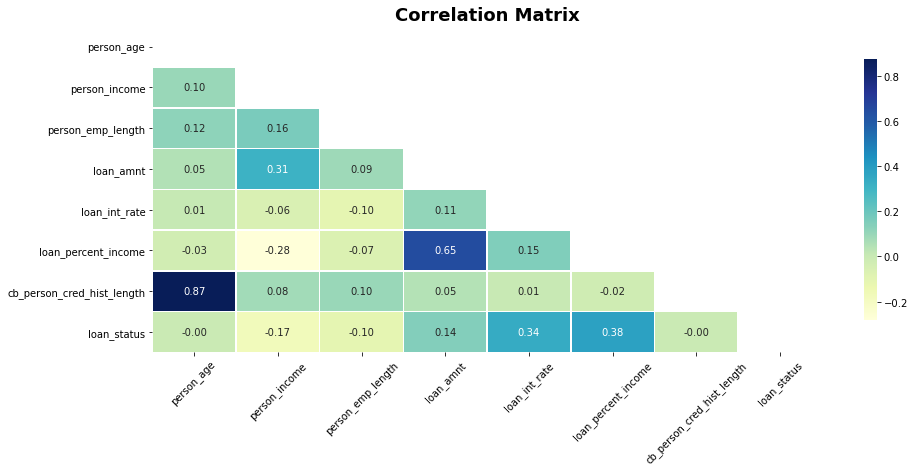

In [91]:
plt.figure(figsize=(15, 6))

# 计算相关矩阵
correlation_matrix = train_df.corr()

# 遮盖住上三角，避免重复信息
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# 绘制热力图
sns.heatmap(correlation_matrix, 
            mask=mask,               # 应用遮罩
            annot=True,             # 显示数值
            cmap='YlGnBu',          
            fmt=".2f",              # 数值保留2位小数
            linewidths=0.5,         # 单元格间隔线宽
            cbar_kws={"shrink": 0.8})  # 缩小颜色条

plt.title('Correlation Matrix', fontsize=18, fontweight='bold')  
plt.xticks(rotation=45)  
plt.yticks(rotation=0)

plt.show()


# Data preprocessing

## Encoding

In [92]:
# categorical_columns:'person_home_ownership', 'loan_intent', 'loan_grade','cb_person_default_on_file'

def categorical_columns_encoding(df):
    # One-Hot : 1.person_home_ownership (房屋所有权) 2.loan_intent (贷款意图) 没有明确的顺序关系，适合One-Hot编码
    df = pd.get_dummies(df, columns=['person_home_ownership'], prefix='home')
    df = pd.get_dummies(df, columns=['loan_intent'], prefix='intent')

    # Ordinal Encoding：loan_grade (贷款评级) 评级有顺序关系，用序数编码
    encoder = OrdinalEncoder(categories=[['A', 'B', 'C', 'D', 'E', 'F', 'G']])
    df['loan_grade'] = encoder.fit_transform(df[['loan_grade']])

    # 二元编码：1.cb_person_default_on_file (历史违约记录) 二元变量
    df['cb_person_default_on_file']=df['cb_person_default_on_file'].map({'N':0,'Y':1})
    return df

In [93]:
train_df=categorical_columns_encoding(train_df)
test_df=categorical_columns_encoding(test_df)

## Feature Engineering

In [94]:
def generate_loan_features(df):
    #1. 贷款收入比：衡量借款人收入覆盖贷款的能力
    df['loan_to_income_ratio'] = df['loan_amnt'] / df['person_income']
    #2. 收入剩余比例：支付贷款后收入所剩的比例
    df['income_left_ratio'] = 1 - df['loan_percent_income']
    #3. 平均年收入：平均每年赚多少钱
    df['income_per_year_emp'] = df['person_income'] / (df['person_emp_length'] + 1)
    #4. 信用历史占年龄比：信用历史长度和年龄的关系
    df['cred_hist_to_age_ratio'] = df['cb_person_cred_hist_length'] / df['person_age']
    #5. 负债信用比：贷款金额与信用历史长度的比值
    df['debt_to_credit_ratio'] = df['loan_amnt'] / df['cb_person_cred_hist_length']
    #6. 利率信用比：贷款利率和信用历史长度的关系
    df['int_to_cred_hist'] = df['loan_int_rate'] / df['cb_person_cred_hist_length']
    #7. 每年贷款额度：贷款金额按工作年限均摊
    df['loan_amt_per_emp_year'] = df['loan_amnt'] / (df['person_emp_length'] + 1)
    #8. 利率与雇佣年限交互：长期工作是否获得更低利率
    df['loan_int_emp_interaction'] = df['loan_int_rate'] * df['person_emp_length']
    #9. 每年利率负担：利率均摊到每个工作年
    df['int_per_year_emp'] = df['loan_int_rate'] / (df['person_emp_length'] + 1)
    #10. 财务负担指数：贷款金额和利率的乘积，衡量还款压力
    df['financial_burden'] = df['loan_amnt'] * df['loan_int_rate']
    #11. 收入贷款比：收入和贷款的直接对比
    df['income_to_loan_ratio'] = df['person_income'] / df['loan_amnt']
    
    return df

In [95]:
train_df=generate_loan_features(train_df)
test_df=generate_loan_features(test_df)

# Model

In [96]:
y = train_df['loan_status'] 
train_df = train_df.drop(['loan_status'],axis=1)
X = train_df

In [97]:
from sklearn.preprocessing import StandardScaler
#数据标准化
scaler = StandardScaler()
scaled_train_data = train_df
scaled_test_data = test_df

In [98]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from lightgbm.callback import early_stopping, log_evaluation

lgb_params = {
    'objective': 'binary',
    'n_estimators': 3000,
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'random_state': 42,
    'learning_rate': 0.0322942967545754,
    'num_leaves': 24,
    'max_depth': 15,
    'min_data_in_leaf': 25,  
    'feature_fraction': 0.6236144085285287, 
    'bagging_fraction': 0.9596685778433888, 
    'bagging_freq': 3,  
    'verbose': -1
}

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
lgbm_predictions = np.zeros(len(scaled_train_data))
lgbm_true_labels = np.zeros(len(scaled_train_data))
lgbm_test_predictions = np.zeros(len(scaled_test_data))

for fold, (train_idx, val_idx) in enumerate(skf.split(scaled_train_data, y)):
    X_train, X_val = scaled_train_data.iloc[train_idx], scaled_train_data.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]    
   
    lgbm_model = LGBMClassifier(**lgb_params)
    lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[
        early_stopping(stopping_rounds=10),
        log_evaluation(period=100)  # 每100轮打印一次日志
    ]
                )   

    lgbm_fold_preds = lgbm_model.predict_proba(X_val)[:, 1]  
    lgbm_fold_test_preds = lgbm_model.predict_proba(scaled_test_data)[:, 1]   
    lgbm_predictions[val_idx] = lgbm_fold_preds
    lgbm_true_labels[val_idx] = y_val    
    lgbm_test_predictions += lgbm_fold_test_preds / n_splits
overall_metric_lgbm = roc_auc_score(lgbm_true_labels, lgbm_predictions)
print("Overall AUC (LGBMClassifier with StratifiedKFold):", overall_metric_lgbm)

Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.937262	valid_0's binary_logloss: 0.174097
[200]	valid_0's auc: 0.947715	valid_0's binary_logloss: 0.161632
Early stopping, best iteration is:
[232]	valid_0's auc: 0.948501	valid_0's binary_logloss: 0.160627
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.950229	valid_0's binary_logloss: 0.159784
[200]	valid_0's auc: 0.958762	valid_0's binary_logloss: 0.145279
Early stopping, best iteration is:
[232]	valid_0's auc: 0.959152	valid_0's binary_logloss: 0.144116
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.943664	valid_0's binary_logloss: 0.168799
[200]	valid_0's auc: 0.952127	valid_0's binary_logloss: 0.156202
Early stopping, best iteration is:
[215]	valid_0's auc: 0.952837	valid_0's binary_logloss: 0.155402
Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.950106	valid_0's binary_logloss: 0.160443
[

In [99]:
catboost_params = {
    'depth': 7,
    'learning_rate': 0.19893301995319765,
    'bagging_temperature': 0.7979373495258176,
    'l2_leaf_reg': 5,
    'loss_function': 'Logloss',
    'iterations': 400,
    'grow_policy': 'Lossguide',
    'eval_metric': 'AUC',
}

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

catboost_predictions = np.zeros(len(scaled_train_data))
catboost_true_labels = np.zeros(len(scaled_train_data))
catboost_test_predictions = np.zeros(len(scaled_test_data))

for fold, (train_idx, val_idx) in enumerate(skf.split(scaled_train_data, y)):
    X_train, X_val = scaled_train_data.iloc[train_idx], scaled_train_data.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    catboost_model = CatBoostClassifier(**catboost_params)
    catboost_model.fit(X_train, y_train,
                       eval_set=(X_val, y_val),
                       early_stopping_rounds=10,
                       verbose=True)
  
    catboost_fold_preds = catboost_model.predict_proba(X_val)[:, 1]  
    catboost_fold_test_preds = catboost_model.predict_proba(scaled_test_data)[:, 1]  
    catboost_predictions[val_idx] = catboost_fold_preds
    catboost_true_labels[val_idx] = y_val    
    catboost_test_predictions += catboost_fold_test_preds / n_splits
overall_metric_catboost = roc_auc_score(catboost_true_labels, catboost_predictions)
print("Overall AUC (CatBoostClassifier with StratifiedKFold):", overall_metric_catboost)

0:	test: 0.8505412	best: 0.8505412 (0)	total: 31.4ms	remaining: 12.5s
1:	test: 0.8622525	best: 0.8622525 (1)	total: 64.9ms	remaining: 12.9s
2:	test: 0.8803525	best: 0.8803525 (2)	total: 98.1ms	remaining: 13s
3:	test: 0.8806541	best: 0.8806541 (3)	total: 127ms	remaining: 12.6s
4:	test: 0.9035659	best: 0.9035659 (4)	total: 158ms	remaining: 12.4s
5:	test: 0.9121739	best: 0.9121739 (5)	total: 190ms	remaining: 12.5s
6:	test: 0.9167153	best: 0.9167153 (6)	total: 225ms	remaining: 12.6s
7:	test: 0.9182098	best: 0.9182098 (7)	total: 257ms	remaining: 12.6s
8:	test: 0.9185521	best: 0.9185521 (8)	total: 287ms	remaining: 12.5s
9:	test: 0.9202754	best: 0.9202754 (9)	total: 319ms	remaining: 12.5s
10:	test: 0.9227773	best: 0.9227773 (10)	total: 355ms	remaining: 12.6s
11:	test: 0.9239009	best: 0.9239009 (11)	total: 384ms	remaining: 12.4s
12:	test: 0.9250063	best: 0.9250063 (12)	total: 413ms	remaining: 12.3s
13:	test: 0.9253768	best: 0.9253768 (13)	total: 445ms	remaining: 12.3s
14:	test: 0.9260597	best:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

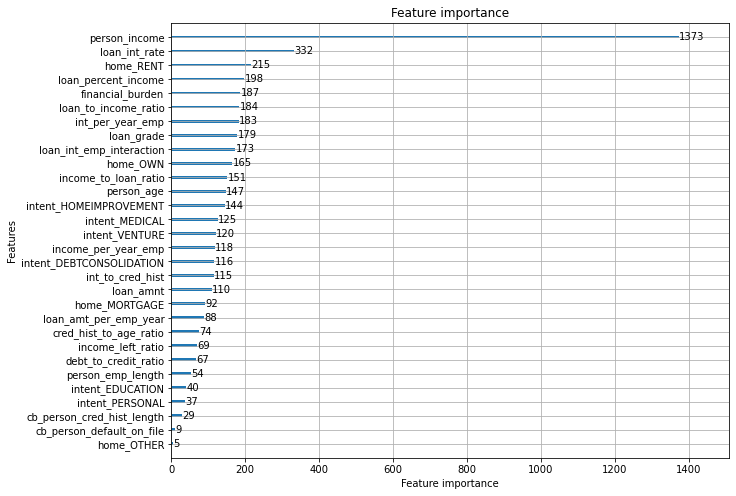

In [100]:
from lightgbm import plot_importance
plot_importance(lgbm_model,figsize=(10, 8))

In [101]:
lgbm_model

LGBMClassifier(bagging_fraction=0.9596685778433888, bagging_freq=3,
               feature_fraction=0.6236144085285287,
               learning_rate=0.0322942967545754, max_depth=15,
               metric='binary_logloss', min_data_in_leaf=25, n_estimators=3000,
               num_leaves=24, objective='binary', random_state=42, verbose=-1)

In [102]:
import lime
import lime.lime_tabular

In [103]:
#数据清理
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(X_train.mean(), inplace=True)
#LIME解释器
X = X_train.values
explainer = lime.lime_tabular.LimeTabularExplainer(X, 
                                                   feature_names=X_train.columns, 
                                                   class_names=['0', '1'], 
                                                   kernel_width=5)
#定义预测函数
predict_fn_lgb = lambda x: lgbm_model.predict_proba(x).astype(float)
#解释单个实例
choosen_instance = X_val.loc[[32558]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_lgb,num_features=15)
#展示解释结果
exp.show_in_notebook(show_all=False)

<ipython-input-103-7f4a785c6635>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-103-7f4a785c6635>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.fillna(X_train.mean(), inplace=True)


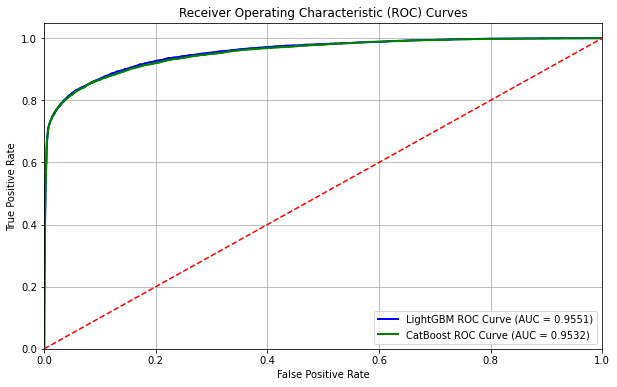

In [104]:
from sklearn.metrics import roc_curve, auc
#计算ROC曲线 fpr_lgbm: 假阳性率。tpr_lgbm: 真阳性率。
fpr_lgbm, tpr_lgbm, _ = roc_curve(lgbm_true_labels, lgbm_predictions)
#AUC值
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm) 

fpr_catboost, tpr_catboost, _ = roc_curve(catboost_true_labels, catboost_predictions)
roc_auc_catboost = auc(fpr_catboost, tpr_catboost)

plt.figure(figsize=(10, 6))
plt.plot(fpr_lgbm, tpr_lgbm, color='blue', lw=2, label=f'LightGBM ROC Curve (AUC = {roc_auc_lgbm:.4f})')
plt.plot(fpr_catboost, tpr_catboost, color='green', lw=2, label=f'CatBoost ROC Curve (AUC = {roc_auc_catboost:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [105]:
# 加权融合预测
sub_df['loan_status'] = lgbm_test_predictions * 0.2 + catboost_test_predictions * 0.8

In [106]:
sub_df.head()

,id,loan_status
0,58645,0.982017
1,58646,0.022021
2,58647,0.563059
3,58648,0.013448
4,58649,0.069178


In [107]:
sub_df.to_csv('submission.csv', index=False)